# Phishing Website Detection and Classification System
   
**Objective:** To develop a Machine Learning system that identifies whether a website URL is safe or malicious

In [1]:
#pip install wordcloud
# %pip install xgboost

### Import Required Libraries

In [2]:

import pandas as pd
import validators
from urllib.parse import urlparse


###  Loads the raw dataset into a Pandas DataFrame for analysis

In [3]:
df = pd.read_csv("ml/data/dataset/malicious_phish.csv")

In [4]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


### Rename Columns for better readability

In [5]:
df = df.rename(columns={"type":"label"})

In [6]:
df.head()

,url,label
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [7]:
df.label.value_counts()

label
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

### Converts textual labels into numeric format

In [8]:
#Mark: 1 -> Phishing, 0 -> Legitimate
label_map = {
    "benign": 0,
    "phishing": 1,
    "defacement": 1,
    "malware": 1
}

df["label"] = df["label"].str.strip().str.lower().map(label_map)

In [9]:
df.head()

,url,label
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1


In [10]:
df.shape

(651191, 2)

### Remove Duplicate and Null Values

In [11]:
#check total duplicates value
df.duplicated().sum()

np.int64(10066)

In [12]:
#remove duplicate value
df = df.drop_duplicates()

In [13]:
df.shape

(641125, 2)

In [14]:
#check null value
df.isnull().sum()

url      0
label    0
dtype: int64

In [15]:
df.dtypes

url      object
label     int64
dtype: object

### Normalize URL formats:

In [16]:
#Lowercase conversion and Remove trailing slashes

df["url"] = df["url"].map(lambda lm : str(lm).strip().lower().strip("/"))

### Add URL Scheme

In [17]:
#add schema "http://" before the url
def fix_url(u):
    if not u.startswith(("http://","https://")):
        u = "http://" + u
    return u

df["url"] = df["url"].apply(fix_url)



### check url is valid or not

In [18]:
def safe_validate(u):
    try:
        return validators.url(u) == True
    except:
        return False

df["is_valid"] = df["url"].map(lambda u: safe_validate(u))

In [19]:
df["is_valid"].value_counts()

is_valid
True     629512
False     11613
Name: count, dtype: int64

#### remove invalid url

In [20]:

df = df[df["is_valid"] == True]

In [21]:
df["is_valid"].value_counts()

is_valid
True    629512
Name: count, dtype: int64

In [22]:
#remove is_valid column
df = df.drop(columns=["is_valid"])

In [23]:
df.head()

,url,label
0,http://br-icloud.com.br,1
1,http://mp3raid.com/music/krizz_kaliko.html,0
2,http://bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,1
4,http://adventure-nicaragua.net/index.php?optio...,1


In [24]:
#save cleaned dataset
df.to_csv("ml/data/dataset/cleaned_dataset.csv", index=False)

### Extracts meaningful numerical features from each URL.

In [25]:
def extract_feature(url):
    features={}
    parsed=urlparse(url)

    features['url_length'] = len(url)
    features['hostname_length'] = len(parsed.netloc)
    features['num_dots'] = url.count('.')
    features['has_https'] = int(url.lower().startswith('http'))
    features['has_ip'] = int(parsed.netloc.replace('.','').isdigit())

    keywords = ['login','secure','varify','account','update','free','bank']
    features['keyword_counts'] = sum(k in url.lower() for k in keywords)
    
    try:
        domain_info = whois.whois(parsed.netloc)
        if domain_info.creation_date:
            creation = domain_info.creation_date
            if isinstance(creation,list):
                creation = creation[0]
            features['domain_age'] = (pd.Timestamp.now()-pd.to_datetime(creation)).days
        else:
            features['domain_age'] = 0
    except:
        features['domain_age'] = 0
    return features

In [26]:
feature_df = df['url'].apply(extract_feature).apply(pd.Series)
full_df = pd.concat([feature_df,df['label']],axis=1)
full_df.to_csv("ml/data/dataset/phishing_processed.csv", index=False)

In [27]:
full_df.head()

,url_length,hostname_length,num_dots,has_https,has_ip,keyword_counts,domain_age,label
0,23,16,2,1,0,0,0,1
1,42,11,2,1,0,0,0,0
2,38,14,2,1,0,0,0,0
3,88,21,3,1,0,0,0,1
4,235,23,2,1,0,0,0,1


### Splits data to avoid overfitting and ensure fair evaluation

In [28]:
from sklearn.model_selection import train_test_split

X = full_df.drop('label',axis=1)
y = full_df['label']

X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.30,random_state=42)

X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=0.50,random_state=42)

In [29]:
train_df = pd.concat([X_train,y_train],axis=1)
val_df = pd.concat([X_val,y_val],axis=1)
test_df = pd.concat([X_test,y_test],axis=1)

In [30]:
train_df.head()

,url_length,hostname_length,num_dots,has_https,has_ip,keyword_counts,domain_age,label
488802,60,20,3,1,0,0,0,1
522940,23,16,3,1,0,0,0,1
314177,65,10,1,1,0,0,0,0
419851,124,17,2,1,0,0,0,1
432914,137,19,5,1,0,0,0,1


In [31]:
train_df.to_csv("ml/data/dataset/train.csv", index=False)
val_df.to_csv("ml/data/dataset/val.csv", index=False)
test_df.to_csv("ml/data/dataset/test.csv", index=False)

In [32]:
train_df.value_counts()

url_length  hostname_length  num_dots  has_https  has_ip  keyword_counts  domain_age  label
38          11               1         1          0       0               0           0        6288
24          17               1         1          0       0               0           0        1764
23          16               1         1          0       0               0           0        1727
25          18               1         1          0       0               0           0        1692
22          15               1         1          0       0               0           0        1673
                                                                                               ... 
629         20               2         1          0       0               0           1           1
653         12               11        1          0       0               0           0           1
690         20               2         1          0       0               0           0           1
699     

In [33]:
val_df.value_counts()

url_length  hostname_length  num_dots  has_https  has_ip  keyword_counts  domain_age  label
38          11               1         1          0       0               0           0        1322
34          14               2         1          0       0               0           1         370
24          17               1         1          0       0               0           0         369
23          16               1         1          0       0               0           0         340
25          18               1         1          0       0               0           0         337
                                                                                               ... 
16          5                1         1          0       0               0           0           1
15          8                2         1          0       0               0           1           1
                             1         1          0       1               0           1           1
        

In [34]:
test_df.value_counts()

url_length  hostname_length  num_dots  has_https  has_ip  keyword_counts  domain_age  label
38          11               1         1          0       0               0           0        1358
34          14               2         1          0       0               0           1         370
24          17               1         1          0       0               0           0         369
25          18               1         1          0       0               0           0         365
22          15               1         1          0       0               0           0         362
                                                                                               ... 
477         226              15        1          0       2               0           0           1
475         13               22        1          0       1               0           1           1
472         12               22        1          0       1               0           1           1
468     

In [35]:
train_df.isnull().sum()

url_length         0
hostname_length    0
num_dots           0
has_https          0
has_ip             0
keyword_counts     0
domain_age         0
label              0
dtype: int64

In [36]:
val_df.isnull().sum()

url_length         0
hostname_length    0
num_dots           0
has_https          0
has_ip             0
keyword_counts     0
domain_age         0
label              0
dtype: int64

In [37]:
test_df.isnull().sum()

url_length         0
hostname_length    0
num_dots           0
has_https          0
has_ip             0
keyword_counts     0
domain_age         0
label              0
dtype: int64

In [38]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_val = val_df.drop("label", axis=1)
y_val = val_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

### Feature Scaling

In [39]:
#Improves performance of models
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Model Training

- ### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_s, y_train)

LogisticRegression(max_iter=1000)

- ### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)  # no scaling needed

RandomForestClassifier(n_estimators=300, random_state=42)

- ### XGBoost

In [42]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

### Model Evaluation

In [43]:
#Evaluates models using precision, recall, f1-score, and accuracy.
from sklearn.metrics import classification_report

print("Logistic Regression")
print(classification_report(y_val, lr.predict(X_val_s)))

print("Random Forest")
print(classification_report(y_val, rf.predict(X_val)))

print("XGBoost")
print(classification_report(y_val, xgb.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     62891
           1       0.68      0.18      0.29     31536

    accuracy                           0.70     94427
   macro avg       0.69      0.57      0.55     94427
weighted avg       0.69      0.70      0.63     94427

Random Forest
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     62891
           1       0.75      0.62      0.68     31536

    accuracy                           0.80     94427
   macro avg       0.79      0.76      0.77     94427
weighted avg       0.80      0.80      0.80     94427

XGBoost
              precision    recall  f1-score   support

           0       0.82      0.89      0.85     62891
           1       0.74      0.61      0.67     31536

    accuracy                           0.80     94427
   macro avg       0.78      0.75      0.76     94427
weighted avg       0.79      0.8

### Hyperparameter Tuning
- Optimizes XGBoost model for better performance

In [44]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

# Initialize the RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=3, 
    scoring='f1', 
    random_state=42,
    n_jobs=-1
)

# Fit the search to the training data
random_search.fit(X_train, y_train)

# print the best parameters and best model
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.1}


In [45]:
best_model = random_search.best_estimator_

print(classification_report(
    y_test,
    best_model.predict(X_test)
))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86     62975
           1       0.75      0.62      0.68     31452

    accuracy                           0.81     94427
   macro avg       0.79      0.76      0.77     94427
weighted avg       0.80      0.81      0.80     94427



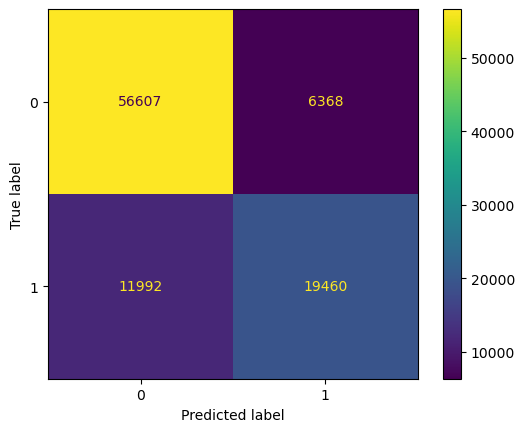

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

### Save Final Model

In [47]:
import pickle

pickle.dump(best_model, open("ml/models/phishing_model.pkl", "wb"))
pickle.dump(scaler, open("ml/models/scaler.pkl", "wb"))

## predict output

In [48]:
model = pickle.load(open("ml/models/phishing_model.pkl", "rb"))

In [49]:
test_url = "https://cdnjs.com/libraries/font-awesome/4.7.0"
#extract feature from url
features = extract_feature(test_url)
#Convert URL into Model Input
input_df = pd.DataFrame([features])
input_df

,url_length,hostname_length,num_dots,has_https,has_ip,keyword_counts,domain_age
0,46,9,3,1,0,0,0


In [50]:
#predict
prediction = model.predict(input_df)
if(prediction==0):
    print("Safe")
else:
    print("danger")

Safe
